In [54]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt


sso_data = Path.cwd().parent / "Data/Option_data/SSO_complete.csv"
parquet_file = (Path.cwd().parent / "Data/Option_data/SSO_complete")

data_path = Path.cwd().parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2019, 1, 1), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r = 14
moneyness_min = 0.65
moneyness_max = 1.35



In [55]:
# pl.read_csv(sso_data, separator = ",").estimated_size("mb")

In [56]:
df = pl.scan_csv(sso_data, separator=",")
df.schema
df.fetch(1000)

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,div_convention,exercise_style
str,str,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,str,i64,str,str,str
"""2016-01-04""","""2016-01-08""","""C""",1000000,0.0,0.49,0,0,1.692439,0.006994,0.000173,1.300576,-100.3955,109965553,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",400000,234.75,238.15,0,0,null,null,null,null,null,109965554,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",410000,224.5,228.2,0,0,null,null,null,null,null,109965555,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",420000,214.75,218.3,0,0,null,null,null,null,null,109965556,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",430000,204.35,208.3,0,0,null,null,null,null,null,109965557,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2016-01-04""","""2016-02-05""","""C""",702500,11.8,12.45,2,3,0.451222,0.253848,0.003764,60.37361,-156.1969,110256313,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-02-05""","""C""",705000,11.25,12.0,20,10,0.45159,0.245625,0.003696,59.31837,-153.6006,110256314,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-02-05""","""C""",710000,10.15,10.75,71,62,0.448326,0.227372,0.003567,56.89643,-146.123,110256315,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""


# Lower the data by use of efficiency and formatting

In [57]:
df.collect().approx_n_unique()

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_22931/3377993439.py:1: DeprecationWarning:

`approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.



date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,div_convention,exercise_style
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1518,331,2,1974,50437,50415,25143,45370,1850090,2010581,179275,15500674,14812822,670224,10,1,11,1,1


In [58]:
#Desired data types for the columns
int_cols = ["strike_price", "volume", "open_interest"]
float_cols = ["best_bid", "best_offer", "impl_volatility", "delta", "gamma", "vega", "theta"]
datetime_cols = ["date","exdate"]
str_cols = ["cp_flag", "ticker", "exercise_style"]
drop_cols = ["optionid", "index_flag", "issuer", "div_convention", "exercise_style"]

In [59]:
#one line to do all the above
df = df.with_columns(
    [ pl.col(int_cols).cast(pl.Int64),
      pl.col(float_cols).cast(pl.Float64),
      pl.col(datetime_cols).cast(pl.Date),
      pl.col(str_cols).cast(pl.String),
    ]
).drop(drop_cols)

In [60]:
df.fetch(5)

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker
date,date,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,str
2016-01-04,2016-01-08,"""C""",1000000,0.0,0.49,0,0,1.692439,0.006994,0.000173,1.300576,-100.3955,"""AMZN"""
2016-01-04,2016-01-08,"""C""",400000,234.75,238.15,0,0,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",410000,224.5,228.2,0,0,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",420000,214.75,218.3,0,0,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",430000,204.35,208.3,0,0,null,null,null,null,null,"""AMZN"""


## Apply filter for volume and open interest

In [61]:
df.filter((pl.col("volume") > 0) & (pl.col("open_interest") > 0)).collect()

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker
date,date,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,str
2016-01-04,2016-01-08,"""C""",570000,66.7,67.25,24,7,null,null,null,null,null,"""AMZN"""
2016-01-04,2016-01-08,"""C""",600000,38.25,38.8,83,8,0.458482,0.898159,0.005818,11.86455,-250.212,"""AMZN"""
2016-01-04,2016-01-08,"""C""",610000,29.45,30.05,155,1,0.443603,0.830513,0.008538,16.8376,-342.8177,"""AMZN"""
2016-01-04,2016-01-08,"""C""",620000,21.45,22.1,186,40,0.429967,0.733626,0.011452,21.89659,-431.2656,"""AMZN"""
2016-01-04,2016-01-08,"""C""",625000,17.9,18.4,240,46,0.422165,0.67466,0.012787,24.01541,-463.9468,"""AMZN"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2021-12-31,2024-01-19,"""P""",325000,53.2,57.5,26,342,0.342074,-0.365889,0.002325,180.8254,-13.624,"""META"""
2021-12-31,2024-01-19,"""P""",335000,58.3,62.5,6,90,0.33902,-0.390563,0.002399,184.4266,-13.70043,"""META"""
2021-12-31,2024-01-19,"""P""",340000,61.05,65.0,6,512,0.337588,-0.402981,0.002433,185.9174,-13.71956,"""META"""


In [62]:
# Saving file
data_path_parq = Path.cwd().parent / "Data/Option_data/sso_complete.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_path_parq):
    df.sink_parquet(data_path_parq)

# Applying the different filters 
- Time period from 2019 - 2022
- 0 to 7 days experiy
- moneyness from 0.8 to 1.2

In [63]:
df = pl.read_parquet(data_path_parq)

# Creating the date filter period
df = df.filter(
    pl.col("exdate").is_between(timeperiod[0], timeperiod[1]),
)
df = df.filter(
    pl.col("date").is_between(timeperiod[0], timeperiod[1]),
)

# Creating the days_till_experire collumn and filter time to maturity
df = df.with_columns(
    days_till_exp = pl.col("exdate").sub(pl.col("date").cast(pl.Int64)) 
).sort("cp_flag").sort("date")

df = df.filter(pl.col("days_till_exp") < days_till_exp_r)

#Creating a filter for the volume and open_interest
df = df.filter((pl.col("volume") > volume_r) & (pl.col("open_interest") > open_interest_r))

#Creating a filter for missing greeks
df = df.filter((pl.col("delta") > delta_r) | (pl.col("gamma") > gamma_r) | (pl.col("vega") > vega_r) | (pl.col("theta") > theta_r))

#Create filter for bid higher than ask price
df = df.filter(pl.col("best_bid") <= pl.col("best_offer"))
df = df.filter(pl.col("best_bid") >= bid_price_r)




#Creating a midprices column
df = df.with_columns(
    bid_diff = pl.col("best_offer").sub(pl.col("best_bid").cast(pl.Float64)) 
).sort("cp_flag").sort("date")

#Filter for the midprice
df = df.filter(pl.col("bid_diff") <= midprice_r)



In [64]:
df

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,days_till_exp,bid_diff
date,date,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,str,i64,f64
2019-01-02,2019-01-04,"""C""",1582500,5.65,5.95,179,143,0.44622,0.205993,0.005604,32.474,-1329.294,"""AMZN""",2,0.3
2019-01-02,2019-01-04,"""C""",1590000,4.5,4.7,591,382,0.450833,0.170195,0.00493,28.83866,-1193.232,"""AMZN""",2,0.2
2019-01-02,2019-01-04,"""C""",1595000,3.7,4.0,332,138,0.450963,0.147503,0.004488,26.27567,-1086.498,"""AMZN""",2,0.3
2019-01-02,2019-01-04,"""C""",1600000,3.1,3.4,8173,4835,0.453011,0.128055,0.004057,23.81642,-990.8325,"""AMZN""",2,0.3
2019-01-02,2019-01-04,"""C""",1602500,2.89,3.15,168,49,0.455694,0.119995,0.003853,22.76705,-952.2318,"""AMZN""",2,0.26
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2021-12-30,2021-12-31,"""P""",340000,0.5,0.54,14792,4633,0.277624,-0.188135,0.053898,4.863976,-245.9593,"""META""",1,0.04
2021-12-30,2021-12-31,"""P""",342500,1.17,1.23,7652,2223,0.278218,-0.352016,0.074,6.688096,-338.9688,"""META""",1,0.06
2021-12-30,2021-12-31,"""P""",345000,2.38,2.48,11159,3165,0.291361,-0.545093,0.075473,7.144706,-378.8639,"""META""",1,0.1


In [65]:
df.approx_n_unique()

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_22931/3764980090.py:1: DeprecationWarning:

`approx_n_unique` is deprecated. Use `select(pl.all().approx_n_unique())` instead.



date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,days_till_exp,bid_diff
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
760,157,2,1744,2202,2198,19371,20136,487207,323404,84323,617898,622729,10,11,263


# Merging the stock prices with the options

In [66]:
stock_path_parq = Path.cwd().parent / "Data/Stock_data/stock_data.parquet"
df_stock = pl.read_parquet(stock_path_parq)

# Convert Polars dataframes to pandas
df = df.to_pandas()
df_stock = df_stock.to_pandas()

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'ticker'})

# Merge 'RET' column from df_stock into df
merged_df = pd.merge(df, df_stock[['ticker', 'date', 'PRC']], on=['ticker', 'date'], how='left')


## Create the moneyness column

In [67]:
# Create 'moneyness' column
merged_df['moneyness'] = merged_df['PRC'] / (merged_df['strike_price'] / 1000)

merged_df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,days_till_exp,bid_diff,PRC,moneyness
0,2019-01-02,2019-01-04,C,1582500,5.65,5.95,179,143,0.446220,0.205993,0.005604,32.474000,-1329.2940,AMZN,2,0.30,1539.13000,0.972594
1,2019-01-02,2019-01-04,C,1590000,4.50,4.70,591,382,0.450833,0.170195,0.004930,28.838660,-1193.2320,AMZN,2,0.20,1539.13000,0.968006
2,2019-01-02,2019-01-04,C,1595000,3.70,4.00,332,138,0.450963,0.147503,0.004488,26.275670,-1086.4980,AMZN,2,0.30,1539.13000,0.964972
3,2019-01-02,2019-01-04,C,1600000,3.10,3.40,8173,4835,0.453011,0.128055,0.004057,23.816420,-990.8325,AMZN,2,0.30,1539.13000,0.961956
4,2019-01-02,2019-01-04,C,1602500,2.89,3.15,168,49,0.455694,0.119995,0.003853,22.767050,-952.2318,AMZN,2,0.26,1539.13000,0.960456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643567,2021-12-30,2021-12-31,P,340000,0.50,0.54,14792,4633,0.277624,-0.188135,0.053898,4.863976,-245.9593,META,1,0.04,344.35999,1.012823
643568,2021-12-30,2021-12-31,P,342500,1.17,1.23,7652,2223,0.278218,-0.352016,0.074000,6.688096,-338.9688,META,1,0.06,344.35999,1.005431
643569,2021-12-30,2021-12-31,P,345000,2.38,2.48,11159,3165,0.291361,-0.545093,0.075473,7.144706,-378.8639,META,1,0.10,344.35999,0.998145
643570,2021-12-30,2021-12-31,P,347500,4.10,4.30,1341,1995,0.318453,-0.703802,0.060234,6.229296,-360.8611,META,1,0.20,344.35999,0.990964


# Create a few filters for the dataframe

In [68]:
#Create moneyness filter
pl_merged = pl.from_pandas(merged_df)

pl_merged = pl_merged.filter((pl.col("moneyness") >= moneyness_min) & (pl.col("moneyness") <= moneyness_max))

pd_merged = pl_merged.to_pandas()


In [81]:
# Amount of observations for the given filters
ticker_counts = pd_merged.groupby('ticker').size()
ticker_counts

ticker
AMZN    137014
BKNG      6039
COHR       558
COST     36996
EXPE     25500
META     69579
MSFT     59484
NVDA     81404
TSLA    101199
WMT      51327
dtype: int64

In [70]:
import pandas as pd
import plotly.graph_objects as go

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-03-19')

# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged[(pd_merged['ticker'] == 'AMZN') & (pd_merged['date'] == date)]
# df_nvda = pd_merged[pd_merged['ticker'] == 'TSLA']
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['days_till_exp'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [82]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-03-19')

# Filter the DataFrame for the 'NVDA' ticker and the specific date
df__nvda = pd_merged[(pd_merged['ticker'] == 'AMZN') & (pd_merged['date'] == date)]
# df_nvda = pd_merged[pd_merged['ticker'] == 'TSLA']

# Create a grid of x and y values
x = np.linspace(df__nvda['moneyness'].min(), df__nvda['moneyness'].max(), len(df__nvda['moneyness'].unique()))
y = np.linspace(df__nvda['days_till_exp'].min(), df__nvda['days_till_exp'].max(), len(df__nvda['days_till_exp'].unique()))
x_grid, y_grid = np.meshgrid(x, y)

# Interpolate z values
z_grid = griddata((df__nvda['moneyness'], df__nvda['days_till_exp']), df__nvda['impl_volatility'], (x_grid, y_grid), method='cubic')

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis')])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

## Plots of the data

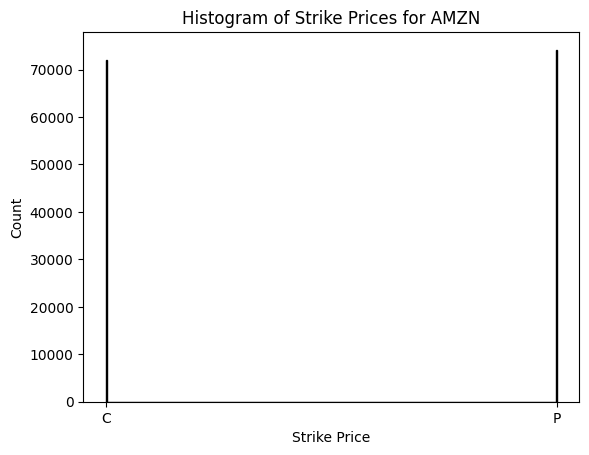

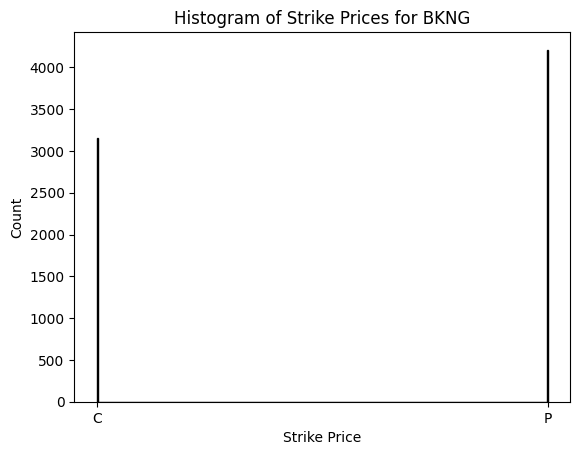

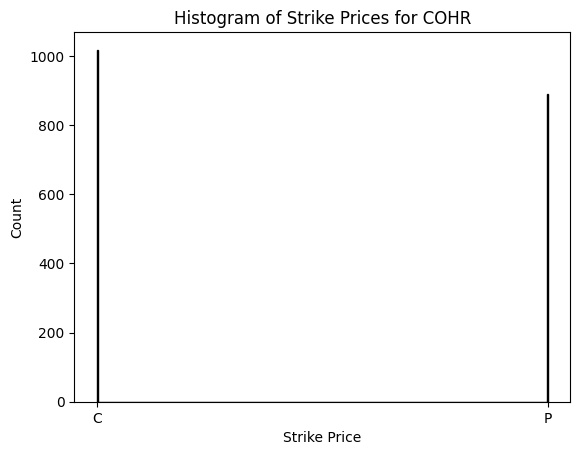

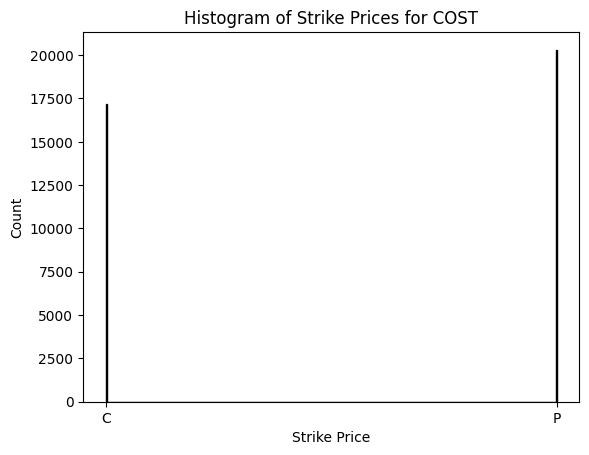

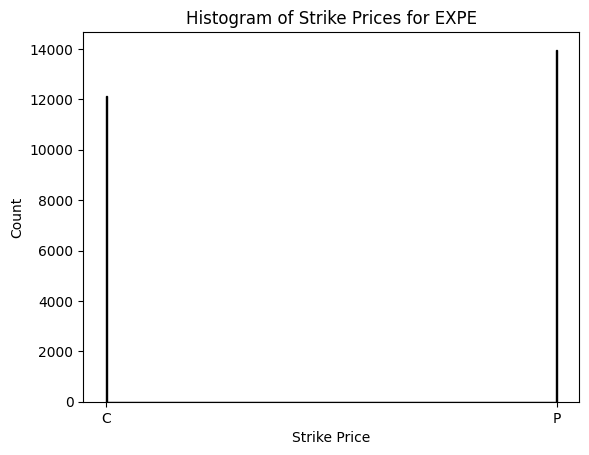

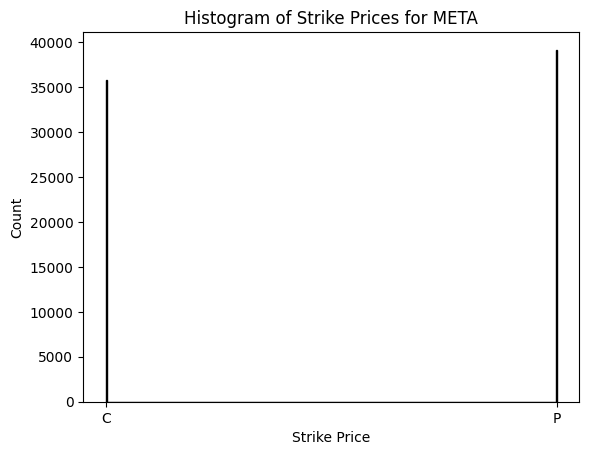

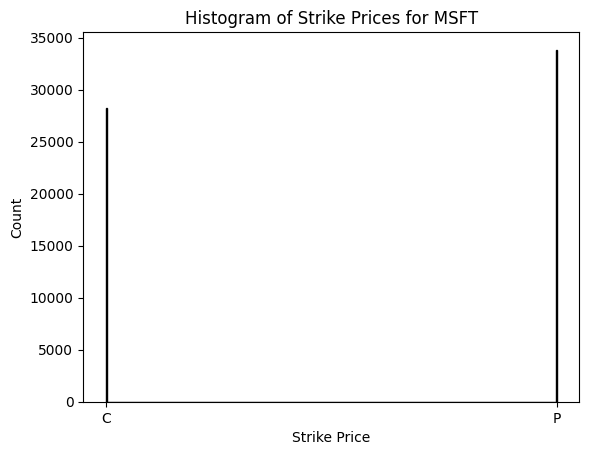

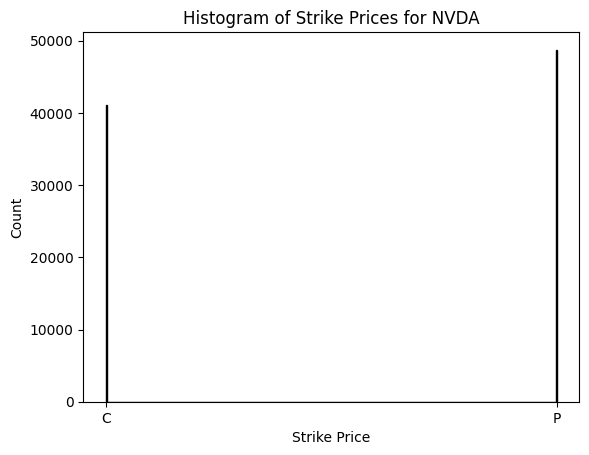

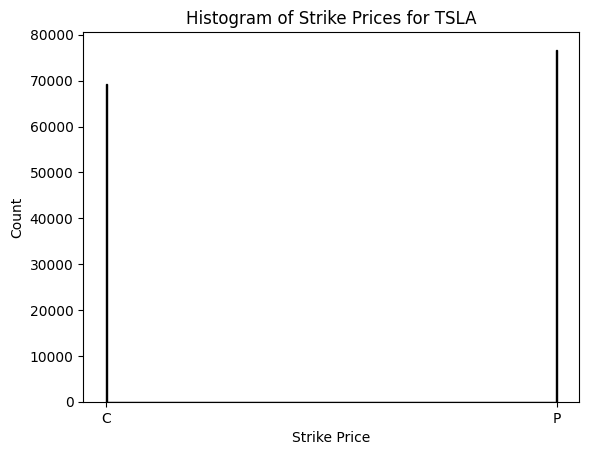

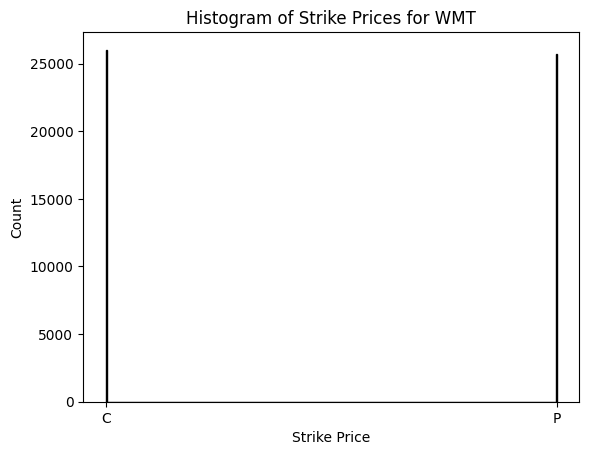

In [83]:
# Group the DataFrame by the 'ticker' column
grouped = merged_df.groupby('ticker')

# Create a separate histogram for each group
for name, group in grouped:
    plt.figure()  # Create a new figure
    plt.hist(group['cp_flag'], bins=500, edgecolor='black')  # Create a histogram of the 'strike_price' column
    plt.title(f'Histogram of Strike Prices for {name}')  # Set the title
    plt.xlabel('Strike Price')  # Set the x-label
    plt.ylabel('Count')  # Set the y-label
    # plt.xlim(0, 2)  # Set the x-limits
    plt.show()  # Show the plot

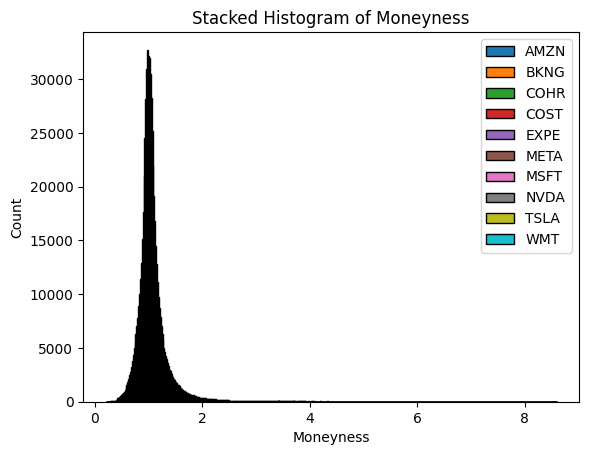

In [84]:
# Group the DataFrame by the 'ticker' column
grouped = merged_df.groupby('ticker')

# Create a list of data for each group
data = [group['moneyness'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, bins=500, stacked=True, edgecolor='black', label=labels)

# Set the title and labels
plt.title('Stacked Histogram of Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

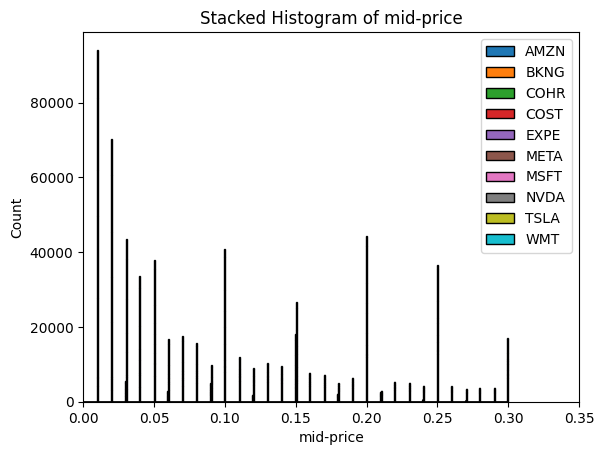

In [85]:
# Group the DataFrame by the 'ticker' column
grouped = merged_df.groupby('ticker')

# Create a list of data for each group
data = [group['bid_diff'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, bins=500, stacked=True, edgecolor='black', label=labels)

# Set the title and labels
plt.title('Stacked Histogram of mid-price')
plt.xlabel('mid-price')
plt.ylabel('Count')

# Set the x-limits
plt.xlim(0, 0.35)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [86]:
# print(type(merged_df))
# sso_info = merged_df[merged_df['ticker'] == 'AMZN']

# sso_info

# Create implied volatility surface

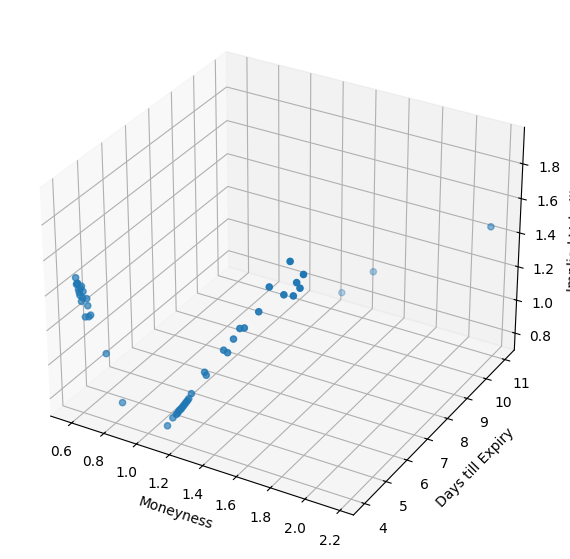

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2020-03-23')

# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = merged_df[(merged_df['ticker'] == 'AMZN') & (merged_df['date'] == date)]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(df_nvda['moneyness'], df_nvda['days_till_exp'], df_nvda['impl_volatility'])

ax.set_xlabel('Moneyness')
ax.set_ylabel('Days till Expiry')
ax.set_zlabel('Implied Volatility')

plt.show()